# ***XG-Boost***

In [40]:
import os
import random
import time
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis

import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
from sklearn.utils.class_weight import compute_sample_weight
import lime.lime_tabular
import time

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [41]:

# =======================
# LOAD DATA
# =======================
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [42]:
# ============================
# FILE PATHS
# ============================
model_filename = "../Models/best_xgb_model.pkl"
study_filename = "../Study/optuna_study_XGB_nested.pkl"
metrics_filename = "../Models/best_xgb_metrics.pkl"
fold_metrics_filename = "./Metrics/xgb_folds_summary.csv"

In [43]:
class XGBWrapper:
    def __init__(self, params, numeric_features, categorical_features):
        self.params = params.copy()
        self.num_boost_round = self.params.pop("num_boost_round")
        self.early_stopping_rounds = self.params.pop("early_stopping_rounds", None)
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.preprocessor = self._build_preprocessor()
        self.model = None
        self.evals_result = None
        self.best_iteration = None
        self.best_score = None

    def _build_preprocessor(self):
        return ColumnTransformer(
            transformers=[
                ('num', SimpleImputer(strategy='median'), self.numeric_features),
                ('cat', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                ]), self.categorical_features)
            ],
            verbose_feature_names_out=False,
            force_int_remainder_cols=False
        )

    def fit(self, X, y, eval_set=None, sample_weight=None):
        self.preprocessor = self._build_preprocessor().fit(X)
        X_proc = self.preprocessor.transform(X)

        if sample_weight is not None:
            dtrain = xgb.DMatrix(X_proc, label=y, weight=sample_weight)
        else:
            dtrain = xgb.DMatrix(X_proc, label=y)

        evals = [(dtrain, "train")]
        evals_result = {}

        if eval_set is not None:
            X_val, y_val = eval_set[0]
            X_val_proc = self.preprocessor.transform(X_val)
            dval = xgb.DMatrix(X_val_proc, label=y_val)
            evals.append((dval, "validation"))

        train_params = {
            'params': self.params,
            'dtrain': dtrain,
            'num_boost_round': self.num_boost_round,
            'evals': evals,
            'evals_result': evals_result,
            'verbose_eval': False
        }

        if self.early_stopping_rounds is not None and len(evals) > 1:
            train_params['early_stopping_rounds'] = self.early_stopping_rounds

        self.model = xgb.train(**train_params)
        self.evals_result = evals_result
        self.best_iteration = getattr(self.model, "best_iteration", None)
        self.best_score = getattr(self.model, "best_score", None)                           

        return self

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        dmatrix = xgb.DMatrix(X_proc)
        y_proba = self.model.predict(dmatrix)
        return np.argmax(y_proba, axis=1)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        dmatrix = xgb.DMatrix(X_proc)
        return self.model.predict(dmatrix)

    def save(self, path):
        joblib.dump({
            "params": self.params,
            "num_boost_round": self.num_boost_round,
            "early_stopping_rounds": self.early_stopping_rounds,
            "numeric_features": self.numeric_features,
            "categorical_features": self.categorical_features,
            "preprocessor": self.preprocessor,
            "booster": self.model,
            "best_iteration": self.best_iteration,
            "best_score": self.best_score
        }, path)

    @classmethod
    def load(cls, path):
        data = joblib.load(path)
        params = {**data["params"], "num_boost_round": data["num_boost_round"]}

        if "early_stopping_rounds" in data:
            params["early_stopping_rounds"] = data["early_stopping_rounds"]

        wrapper = cls(
            params,
            data["numeric_features"],
            data["categorical_features"]
        )
        wrapper.preprocessor = data["preprocessor"]
        wrapper.model = data["booster"]
        wrapper.best_iteration = data.get("best_iteration")
        wrapper.best_score = data.get("best_score")
        return wrapper


In [44]:
# ============================
# MODEL EVALUATION
# ============================
def evaluate_model(model, X_data, y_data):
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    loss = log_loss(y_data, y_proba)
    auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, loss, auc, report, cm, y_proba, y_pred

In [45]:
# ============================
# LIME EXPLAINER BUILDER
# ============================
def get_lime_explainer(model_wrapper, X_train_raw, y_train_raw):
    X_transformed = model_wrapper.preprocessor.transform(X_train_raw)
    feature_names = model_wrapper.preprocessor.get_feature_names_out()
    class_names = np.unique(y_train_raw).astype(str)
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_transformed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    return explainer, X_transformed

In [46]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "verbosity": 0,
            "objective": "multi:softprob",
            "num_class": len(np.unique(y_inner)),
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
            "max_depth": trial.suggest_int("max_depth", 4, 8),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "tree_method": "hist",
            "device": "cuda",
            "seed": SEED,
            "num_boost_round": trial.suggest_int("num_boost_round", 50, 250),
            "early_stopping_rounds": 10
        }

        # Extra dropout config if booster is dart
        if params["booster"] == "dart":
            params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            params["rate_drop"] = trial.suggest_float("rate_drop", 0.1, 0.5)
            params["skip_drop"] = trial.suggest_float("skip_drop", 0.0, 0.5)
        
        model = XGBWrapper(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []
        
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            
            sample_weights = compute_sample_weight("balanced", y_t)
            
            eval_set = [(X_v, y_v)]
            
            model.fit(X_t, y_t, eval_set=eval_set, sample_weight=sample_weights)
            
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        
        return np.mean(scores)
    
    pruner = MedianPruner()
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, n_jobs=10)
    
    return study.best_params, study

In [47]:
# ============================
# FOLD METRIC SAVER
# ============================
def save_metrics_folds(folds_metrics: list, filename: str) -> pd.DataFrame:
    df = pd.DataFrame(folds_metrics)
    metric_cols = df.columns.drop('fold') if 'fold' in df.columns else df.columns
    mean_row = df[metric_cols].mean().to_dict()
    std_row = df[metric_cols].std().to_dict()
    mean_row['fold'] = 'mean'
    std_row['fold'] = 'std'
    df_final = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)
    df_final.to_csv(filename, index=False)
    print(f"\n📁 Fold metrics + summary saved to: {filename}")
    return df_final

# ============================
# CONFUSION MATRIX PLOTTER
# ============================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

In [48]:

# ============================
# NESTED CV
# ============================
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total = outer_cv.get_n_splits(),
        desc="Training folds"
    ):
        
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold,
            test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)
        
        best_params["objective"] = "multi:softprob"
        best_params["num_class"] = 3       
        best_params["tree_method"] = "hist"
        best_params["device"] = "cuda"
        best_params["verbosity"] = 0
        best_params["seed"] = SEED

        model = XGBWrapper(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }
            
    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [49]:
# Run pipeline
categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [50]:
model

In [51]:
metrics.keys()

dict_keys(['fold', 'f1_train', 'accuracy_train', 'log_loss_train', 'auc_train', 'f1_val', 'accuracy_val', 'log_loss_val', 'auc_val', 'f1_test', 'accuracy_test', 'log_loss_test', 'auc_test', 'optuna_time', 'params', 'labels', 'best_fold', 'X_train_fold', 'y_train_fold', 'y_train_pred', 'y_train_true', 'y_proba_train', 'classification_report_train', 'confusion_matrix_train', 'y_val_true', 'y_val_pred', 'y_proba_val', 'classification_report_val', 'confusion_matrix_val', 'y_test_fold', 'y_test_pred', 'y_proba_test', 'classification_report_test', 'confusion_matrix_test'])

In [52]:
print(metrics['classification_report_train'])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13701
           1       0.98      0.96      0.97      4136
           2       0.99      0.94      0.96      2499

    accuracy                           0.98     20336
   macro avg       0.98      0.96      0.97     20336
weighted avg       0.98      0.98      0.98     20336



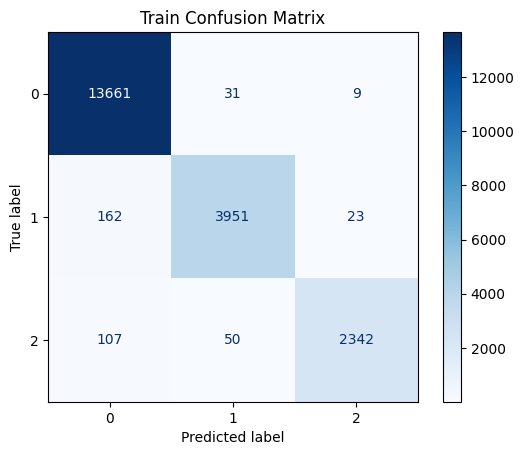

In [53]:
plot_confusion_matrix(metrics['confusion_matrix_train'], metrics['labels'], "Train Confusion Matrix")

In [54]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3426
           1       0.80      0.74      0.77      1034
           2       0.83      0.72      0.77       625

    accuracy                           0.89      5085
   macro avg       0.85      0.81      0.83      5085
weighted avg       0.89      0.89      0.89      5085



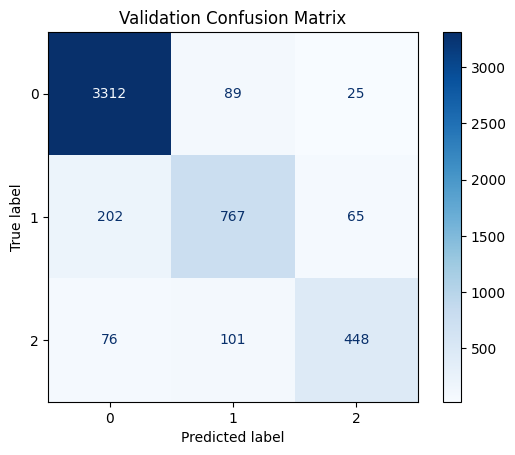

In [55]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [56]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4281
           1       0.80      0.73      0.76      1293
           2       0.82      0.73      0.77       782

    accuracy                           0.89      6356
   macro avg       0.85      0.81      0.82      6356
weighted avg       0.88      0.89      0.88      6356



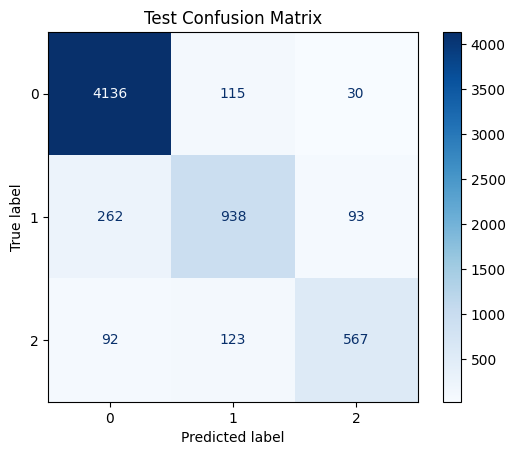

In [57]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

In [58]:
def plot_loss_curves(model):
    """
    Plots train and validation log loss over boosting rounds.
    Adds a vertical line at the best_iteration if available.
    """
    if not hasattr(model, "evals_result"):
        raise ValueError("The model has no evaluation history.")

    results = model.evals_result
    for dataset in results:
        if "mlogloss" in results[dataset]:
            plt.plot(results[dataset]["mlogloss"], label=f"{dataset} logloss")

    plt.xlabel("Boosting round")
    plt.ylabel("Log loss")
    plt.title("Log loss - train vs validation")
    plt.legend()
    plt.grid(True)

    if hasattr(model, "best_iteration") and model.best_iteration is not None:
        plt.axvline(x=model.best_iteration, color="red", linestyle="--", label="Best iteration")
        plt.legend()

    plt.show()


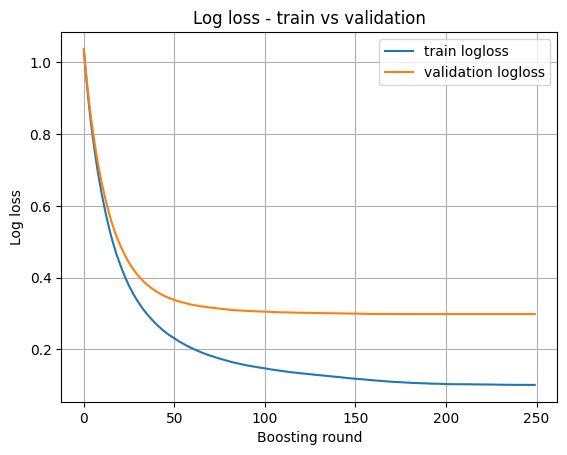

In [59]:
plot_loss_curves(model)

In [60]:
model

--- Explanation for class 0 ---


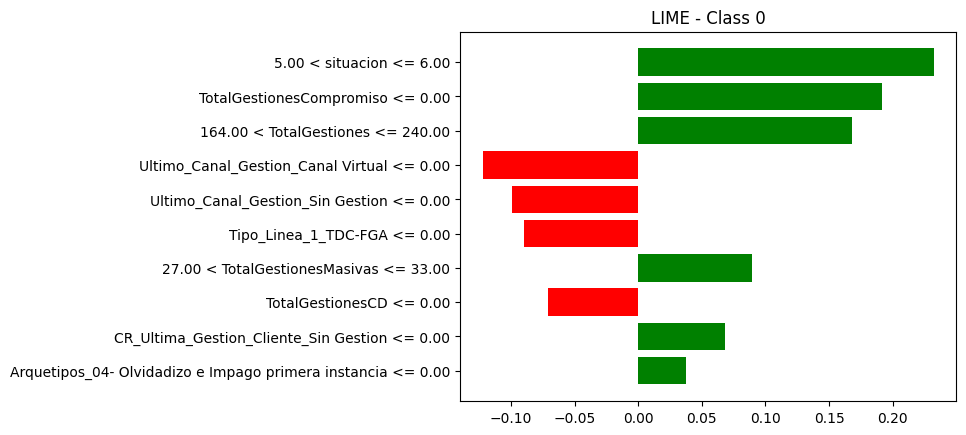

--- Explanation for class 1 ---


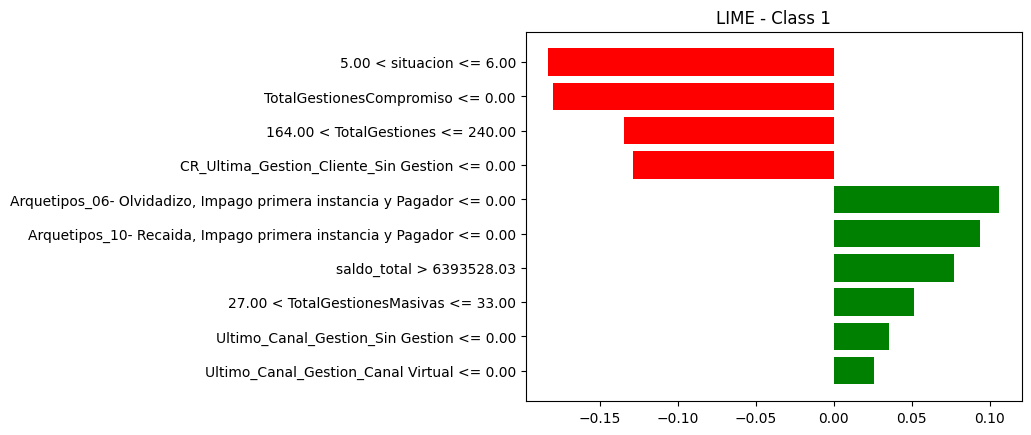

--- Explanation for class 2 ---


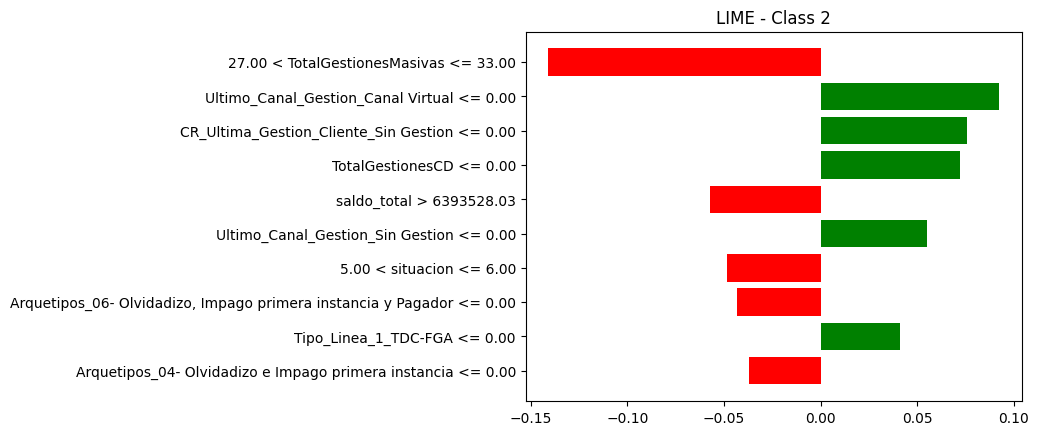

In [61]:
X_transformed = model.preprocessor.transform(metrics['X_train_fold'])

def predict_fn(x):
    dmatrix = xgb.DMatrix(x)
    return model.model.predict(dmatrix)

feature_names = model.preprocessor.get_feature_names_out()
class_names = np.unique(metrics['y_train_fold']).astype(str)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

instance = X_transformed[10]
exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])

exp.show_in_notebook(show_table=True)

for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [62]:
study

In [63]:
visualizations.keys()

dict_keys(['optimization_history', 'parallel_coordinate', 'param_importances', 'f1_score_evolution'])

In [64]:
visualizations['optimization_history']

In [65]:
visualizations['parallel_coordinate']

In [66]:
visualizations['f1_score_evolution']

In [67]:
visualizations['param_importances']

In [68]:
raw_importances = model.model.get_score(importance_type='gain')

feature_names = model.preprocessor.get_feature_names_out()

mapped_importances = []
for i, fname in enumerate(feature_names):
    score = raw_importances.get(f"f{i}", 0)
    mapped_importances.append((fname, score))

importance_df = pd.DataFrame(mapped_importances, columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False).head(20)

fig = px.bar(
    importance_df,
    x='Feature',
    y='Importance',
    title='Top 20 Feature Importance - XGBoost',
    labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
    color='Importance',
    color_continuous_scale='Viridis',
    text='Importance'
)
fig.update_layout(xaxis_tickangle=45)
fig.show()


In [30]:
reporte.save(metrics, model_name="XGBOOST")


✅ Report for model 'XGBOOST' saved:
   → CSV: ./Metrics/Metrics_XGBOOST.csv
   → JSON: ./Metrics/Metrics_XGBOOST.json


In [31]:
df = reporte.load()


✅ Loaded 5 report(s):
   → Models: ['RF', 'LGBM', 'SVC', 'CART', 'XGBOOST']
   → Types : ['train', 'val', 'test']


In [32]:
df.query("Model == 'XGBOOST' and Type == 'train' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
72,XGBOOST,train,0,0.981,0.997,0.989
73,XGBOOST,train,1,0.98,0.955,0.967
74,XGBOOST,train,2,0.987,0.937,0.961
75,XGBOOST,train,macro avg,0.982,0.963,0.972
76,XGBOOST,train,weighted avg,0.981,0.981,0.981


In [33]:
df.query("Model == 'XGBOOST' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
78,XGBOOST,val,0,0.923,0.967,0.944
79,XGBOOST,val,1,0.801,0.742,0.77
80,XGBOOST,val,2,0.833,0.717,0.77
81,XGBOOST,val,macro avg,0.852,0.808,0.828
82,XGBOOST,val,weighted avg,0.887,0.89,0.887


In [34]:
df.query("Model == 'XGBOOST' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
84,XGBOOST,test,0,0.921,0.966,0.943
85,XGBOOST,test,1,0.798,0.725,0.76
86,XGBOOST,test,2,0.822,0.725,0.77
87,XGBOOST,test,macro avg,0.847,0.806,0.824
88,XGBOOST,test,weighted avg,0.884,0.888,0.885


In [35]:
df.query("Model == 'XGBOOST' and auc != '-'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
77,XGBOOST,train,0.981,0.101,0.999
83,XGBOOST,val,0.89,0.298,0.965
89,XGBOOST,test,0.888,0.298,0.966


In [36]:
df.query("Model == 'XGBOOST' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
83,XGBOOST,val,0.89,0.298,0.965


In [37]:
def plot_roc_multiclass(y_true, y_proba, class_labels, title="AUC-ROC Curve (Multiclass)"):
    # Binarize true labels
    y_bin = label_binarize(y_true, classes=class_labels)
    n_classes = len(class_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


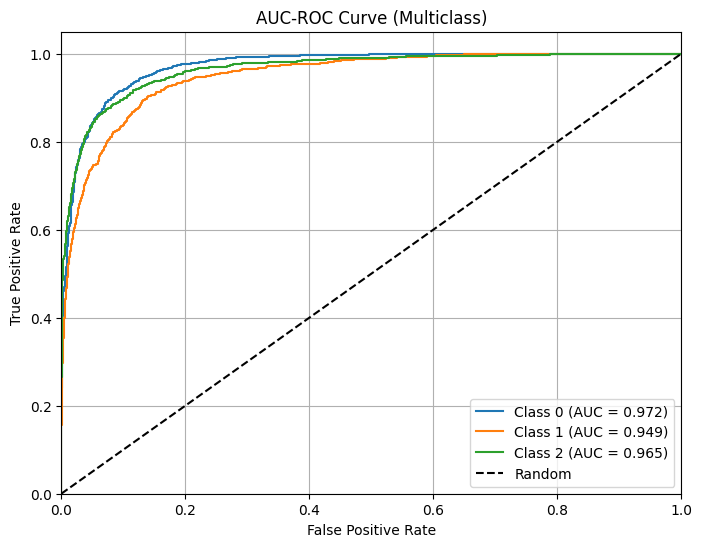

In [38]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

In [39]:
model.params  

{'booster': 'gbtree',
 'lambda': 0.021233905392815642,
 'alpha': 0.004182598627755913,
 'subsample': 0.9716917132914629,
 'colsample_bytree': 0.8910644772655356,
 'colsample_bylevel': 0.9464017731790374,
 'max_depth': 8,
 'min_child_weight': 2,
 'gamma': 0.47587092350899507,
 'learning_rate': 0.06043309334367481,
 'objective': 'multi:softprob',
 'num_class': 3,
 'tree_method': 'hist',
 'device': 'cuda',
 'verbosity': 0,
 'seed': 42}